In [91]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO, Evaluator

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import utils
from torch import optim
from torch import device
from torch import inference_mode

import tqdm
from timeit import default_timer as timer
from tqdm.auto import tqdm

from torchmetrics import ConfusionMatrix

import mlxtend
from mlxtend.plotting import plot_confusion_matrix

In [92]:
device = "cuda" if torch.cuda.is_available() else "cpu"

data_flag = 'pneumoniamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_data = DataClass(split='train', transform=data_transform, download=True)
test_data = DataClass(split='test', transform=data_transform, download=True)
val_data = DataClass(split='val', transform=data_transform, download=True)

Using downloaded and verified file: /Users/ishaan/.medmnist/pneumoniamnist.npz


Using downloaded and verified file: /Users/ishaan/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/ishaan/.medmnist/pneumoniamnist.npz


In [93]:
# Checking Data Organization
img = train_data[0][0]
label = train_data[0][1]

print(f"Image:\n {img}") 
print(f"Label:\n {label}")

print(f"Image shape: {img.shape}")
print(f"Label: {label}")

Image:
 tensor([[[-0.2784, -0.1529, -0.0824, -0.1294, -0.2078, -0.2941, -0.4510,
          -0.6157, -0.7804, -0.5294, -0.3490, -0.0667,  0.2235,  0.4588,
           0.6549,  0.6000,  0.5059,  0.5922,  0.6000,  0.3020, -0.0980,
          -0.2941, -0.5843, -1.0000, -1.0000, -0.9608, -0.9373, -0.9529],
         [ 0.0118,  0.0824,  0.1059,  0.0353, -0.0588, -0.1294, -0.2157,
          -0.3020, -0.2392, -0.1373, -0.1765, -0.0824,  0.1294,  0.3569,
           0.5294,  0.4196,  0.5216,  0.5137,  0.3961,  0.1137, -0.1373,
          -0.2784, -0.5529, -0.9137, -0.9529, -0.9686, -0.9843, -0.9765],
         [ 0.1059,  0.1451,  0.1608,  0.1216,  0.0510,  0.0039, -0.0118,
          -0.0118,  0.0980,  0.2235,  0.1216,  0.0745,  0.1294,  0.2706,
           0.4118,  0.2941,  0.2471,  0.3020,  0.2157,  0.0588, -0.0118,
          -0.1373, -0.3804, -0.5686, -0.9373, -1.0000, -1.0000, -1.0000],
         [-0.0588, -0.0118,  0.0588,  0.0902,  0.0902,  0.0824,  0.1216,
           0.1765,  0.0588,  0.3490,  0.

In [94]:
# Number of image channels
n_channels = info['n_channels']
print(f"number of channels: {n_channels}")

# Number of classes
n_classes = len(info['label'])
print(f"number of classes: {n_classes}")

# Get the class names from the dataset
class_names = info['label']
print(f"class names: {class_names}")

number of channels: 1
number of classes: 2
class names: {'0': 'normal', '1': 'pneumonia'}


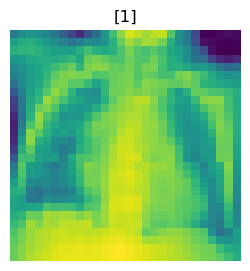

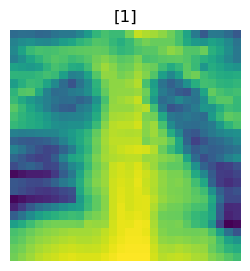

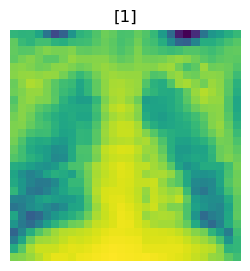

In [95]:
# Test Plots
for i in range(3):
    img = train_data[i][0]
    label = train_data[i][1]
    plt.figure(figsize=(3, 3))
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)
    plt.axis(False);

In [96]:
# Dataloader
BATCH_SIZE = 128
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [97]:
# Test Dataloader
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x32e4ca1d0>, <torch.utils.data.dataloader.DataLoader object at 0x332b59610>)
Length of train dataloader: 37 batches of 128
Length of test dataloader: 5 batches of 128
Length of val dataloader: 5 batches of 128


In [98]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    
    for batch, (X, y) in enumerate(data_loader):
        # need to change target shape for this medmnist data 
        y = y.squeeze().long()
        
        # Send data to selected device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch 
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    return train_loss, train_acc

In [99]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    model.to(device)
    
    model.eval() # eval mode for testing
    with torch.inference_mode(): # Inference context manager
        for X, y in data_loader:
            # need to change target shape for this medmnist data 
            y = y.squeeze().long()
            
            # Send data to selected device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
        return test_loss, test_acc

In [100]:
def eval_func(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    
    eval_loss, eval_acc = 0, 0
    model.to(device)
    
    model.eval()
    y_preds = []
    y_targets = []
    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(data_loader)):
            # need to change target shape for this medmnist data 
            y = y.squeeze().long()
            
            # Send data to selected device
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            eval_pred = model(X)
            
            # Find loss and accuracy
            eval_loss += loss_fn(eval_pred, y)
            eval_acc += accuracy_fn(y_true=y,
                                    y_pred=eval_pred.argmax(dim=1))

            # Add prediction and target labels to list
            eval_labels = torch.argmax(torch.softmax(eval_pred, dim=1), dim=1)
            y_preds.append(eval_labels)
            y_targets.append(y)

        # Scale loss and acc 
        eval_loss /= len(data_loader)
        eval_acc /= len(data_loader)
        
        # Put predictions on CPU for evaluation
        y_preds=torch.cat(y_preds).cpu() 
        y_targets=torch.cat(y_targets).cpu() 
        
        return {"model_name": model.__class__.__name__, 
                "loss": eval_loss.item(),
                "accuracy": eval_acc,
                "predictions": y_preds,
                "targets": y_targets}

In [101]:
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [102]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

In [103]:
class cnn(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units, 
                      kernel_size=3),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units*4, 
                      kernel_size=3),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4, 
                      out_channels=hidden_units*4, 
                      kernel_size=3),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4, 
                      out_channels=hidden_units*4, 
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2))

        self.fc = nn.Sequential(
            nn.Linear(hidden_units*4 * 4 * 4, hidden_units*8),
            nn.ReLU(),
            nn.Linear(hidden_units*8, hidden_units*8),
            nn.ReLU(),
            nn.Linear(hidden_units*8, n_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    
# Define Model
model = cnn(input_shape=n_channels, 
                     hidden_units=16,
                     output_shape=n_classes).to(device)


# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# View Model
model

cnn(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=

In [104]:
torch.manual_seed(42)

# Measure Time

train_time_start_model = timer()

iteration_loss_list = []
iteration_accuracy_list = []

# set parameters
epochs = 50
best_loss = 10

# call train and test function
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(data_loader=train_dataloader,
                                       model=model,
                                       loss_fn = loss_fn,
                                       optimizer=optimizer,
                                       accuracy_fn=accuracy_fn,
                                       device=device)
    
    test_loss, test_acc = test_step(data_loader=test_dataloader,
                                    model=model,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)
    
    for iteration, (x, y) in enumerate(train_dataloader):
        iteration_loss_list.append(train_loss.item())
        iteration_accuracy_list.append(train_acc)

    
    print(f"Epoch: {epoch} | Training loss: {train_loss:.3f} | Training acc: {train_acc:.2f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.2f}")

    # save best model instance

    if test_loss < best_loss:
        best_loss = test_loss
        print(f"Saving best model for epoch: {epoch}")
        torch.save(obj=model.state_dict(), 
                   f="./organa_model.pth")

        
train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Training loss: 0.595 | Training acc: 65.10 | Test loss: 0.621 | Test acc: 62.59
Saving best model for epoch: 0
Epoch: 1 | Training loss: 0.341 | Training acc: 85.62 | Test loss: 0.309 | Test acc: 87.50
Saving best model for epoch: 1
Epoch: 2 | Training loss: 0.178 | Training acc: 92.72 | Test loss: 0.443 | Test acc: 82.03
Epoch: 3 | Training loss: 0.147 | Training acc: 94.02 | Test loss: 0.433 | Test acc: 83.95
Epoch: 4 | Training loss: 0.128 | Training acc: 94.68 | Test loss: 0.416 | Test acc: 84.44
Epoch: 5 | Training loss: 0.124 | Training acc: 94.93 | Test loss: 0.432 | Test acc: 83.97
Epoch: 6 | Training loss: 0.111 | Training acc: 95.70 | Test loss: 0.565 | Test acc: 80.92
Epoch: 7 | Training loss: 0.103 | Training acc: 95.94 | Test loss: 0.380 | Test acc: 87.30
Epoch: 8 | Training loss: 0.101 | Training acc: 96.06 | Test loss: 0.285 | Test acc: 91.16
Saving best model for epoch: 8
Epoch: 9 | Training loss: 0.103 | Training acc: 95.87 | Test loss: 0.357 | Test acc: 88.

In [107]:
# Load model
loaded_model = cnn(input_shape=n_channels,
                   hidden_units=16,
                   output_shape=n_classes).to(device)

loaded_model.load_state_dict(torch.load(f="./organa_model.pth"))

# get results
model_results = eval_func(data_loader=val_dataloader,
                          model=loaded_model,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn,
                          device=device)

model_results

0it [00:00, ?it/s]

{'model_name': 'cnn',
 'loss': 0.21601763367652893,
 'accuracy': 90.98958333333333,
 'predictions': tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
         1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
         1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
         0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
         0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
         1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
         0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
         0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
         0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
         1

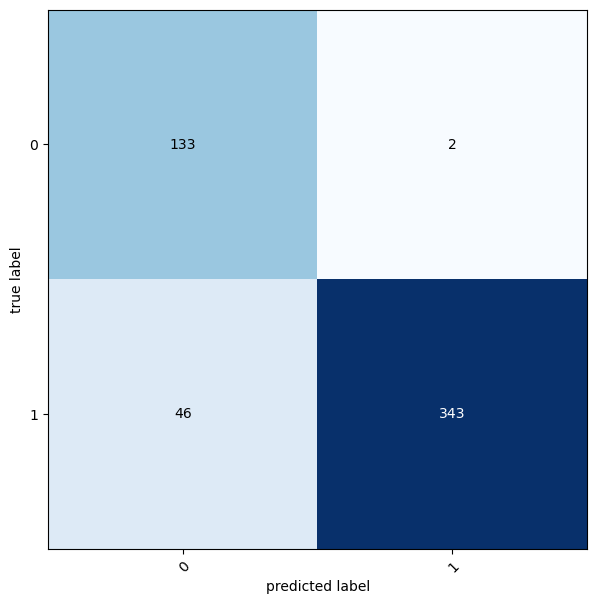

In [108]:
# Get Model predictions and true targets
y_targets = model_results['targets']
y_preds = model_results['predictions']

# Setup confusion matrix 
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=y_targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

{'confmat': tensor([[133,   2],
         [ 46, 343]])}